# Synthesis & Comparison: Three Approaches to approximate Lorenz Dynamics

We've trained three distinct neural network architectures on the same task:
1. **Continuous-Time RNN** (CT-RNN)
2. **Balanced Excitatory-Inhibitory Rate Network**
3. **Balanced Spiking Network** (trained & reservoir)

Now let's compare them across multiple dimensions:
- **Performance**: Prediction accuracy (R², RMSE, MAE)
- **Dynamics**: Attractor geometry, chaos, complexity
- **Efficiency**: Training time, inference speed, parameter count
- **Biology**: E/I balance, Dale's law, spiking

This comparison reveals **architectural trade-offs** and helps answer:
- Which architecture is best for what purpose?
- What do we sacrifice for biological plausibility?
- How do constraints shape learned dynamics?

In [ ]:
# Setup
import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install -q torch torchdiffeq norse matplotlib scipy tqdm
    !git clone -q https://github.com/CNNC-Lab/RNNs-tutorial.git
    %cd RNNs-tutorial
    
    # Install the package in editable mode
    !pip install -q -e .

from src import setup_environment, check_dependencies

check_dependencies()
device = setup_environment()

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
import torch.nn as nn
import pandas as pd
from src.data import create_shared_dataloaders
from src.models import ContinuousTimeRNN
from src.utils import evaluate, compute_prediction_metrics

print("✓ All imports successful!")

## Part 1: Load All Trained Models

Let's load all the models we trained in notebooks 01-03.

In [2]:
# Load shared dataset
train_loader, val_loader, test_loader, info = create_shared_dataloaders(
    dataset_path='../data/processed/lorenz_data.npz',
    batch_size=64
)

mean = info['normalization']['mean']
std = info['normalization']['std']
dt = info['dt']

✓ Dataset loaded from ../data/processed/lorenz_data.npz
  Train: (14000, 3), Val: (3000, 3), Test: (3000, 3)
  dt=0.01, seq_length=50


In [3]:
# 1. Load CT-RNN
ctrnn = ContinuousTimeRNN(input_size=3, hidden_size=64, output_size=3, tau=1.0, solver='euler').to(device)
try:
    ctrnn.load_state_dict(torch.load('checkpoints/ctrnn_best.pt', map_location=device))
    ctrnn.eval()
    n_params_ctrnn = sum(p.numel() for p in ctrnn.parameters())
except FileNotFoundError:
    ctrnn = None
    n_params_ctrnn = 0

In [4]:
# 2. Load Balanced Rate Network
# Note: Uses inline implementation to match notebook 02 checkpoint
import torch.nn.functional as F

class BalancedRateRNN(nn.Module):
    """Balanced E/I Rate Network (must match notebook 02 architecture for checkpoint loading)"""
    def __init__(self, input_size=3, n_excitatory=48, n_inhibitory=16, output_size=3,
                 tau_e=1.0, tau_i=0.5, dt=0.1, activation='relu'):
        super().__init__()
        self.n_e = n_excitatory
        self.n_i = n_inhibitory
        self.tau_e = tau_e
        self.tau_i = tau_i
        self.dt = dt
        self.activation = F.relu if activation == 'relu' else torch.tanh
        
        self.W_in_e = nn.Linear(input_size, n_excitatory, bias=True)
        self.W_in_i = nn.Linear(input_size, n_inhibitory, bias=True)
        
        self.W_ee = nn.Parameter(torch.randn(n_excitatory, n_excitatory) * 0.5 / np.sqrt(n_excitatory))
        self.W_ei = nn.Parameter(torch.randn(n_excitatory, n_inhibitory) * 0.5 / np.sqrt(n_inhibitory))
        self.W_ie = nn.Parameter(torch.randn(n_inhibitory, n_excitatory) * 0.5 / np.sqrt(n_excitatory))
        self.W_ii = nn.Parameter(torch.randn(n_inhibitory, n_inhibitory) * 0.5 / np.sqrt(n_inhibitory))
        
        self.decoder = nn.Linear(n_excitatory, output_size)
    
    def get_dale_weights(self):
        return torch.abs(self.W_ee), torch.abs(self.W_ei), torch.abs(self.W_ie), torch.abs(self.W_ii)
    
    def step(self, r_e, r_i, x):
        W_ee, W_ei, W_ie, W_ii = self.get_dale_weights()
        inp_e = self.W_in_e(x)
        inp_i = self.W_in_i(x)
        I_e = torch.matmul(r_e, W_ee.t()) - torch.matmul(r_i, W_ei.t()) + inp_e
        I_i = torch.matmul(r_e, W_ie.t()) - torch.matmul(r_i, W_ii.t()) + inp_i
        dr_e = (self.dt / self.tau_e) * (-r_e + self.activation(I_e))
        dr_i = (self.dt / self.tau_i) * (-r_i + self.activation(I_i))
        return r_e + dr_e, r_i + dr_i
    
    def forward(self, x):
        batch_size, seq_len, _ = x.shape
        r_e = torch.zeros(batch_size, self.n_e, device=x.device)
        r_i = torch.zeros(batch_size, self.n_i, device=x.device)
        for t in range(seq_len):
            r_e, r_i = self.step(r_e, r_i, x[:, t, :])
        return self.decoder(r_e)

balanced_rate = BalancedRateRNN(input_size=3, n_excitatory=48, n_inhibitory=16, output_size=3).to(device)
try:
    balanced_rate.load_state_dict(torch.load('checkpoints/balanced_rate_best.pt', map_location=device))
    balanced_rate.eval()
    n_params_balanced = sum(p.numel() for p in balanced_rate.parameters())
except FileNotFoundError:
    balanced_rate = None
    n_params_balanced = 0

In [5]:
# 3. Load Balanced Spiking Networks
from src.models import BalancedSpikingNetwork

snn_trained = BalancedSpikingNetwork(
    input_size=3, n_excitatory=128, n_inhibitory=32, output_size=3,
    tau_mem_e=2.0, tau_mem_i=1.0, fixed_weights=False, readout_mode='rate'
).to(device)

try:
    snn_trained.load_state_dict(torch.load('checkpoints/snn_trained_best.pt', map_location=device))
    snn_trained.eval()
    n_params_snn_trained = sum(p.numel() for p in snn_trained.parameters() if p.requires_grad)
except FileNotFoundError:
    snn_trained = None
    n_params_snn_trained = 0

snn_reservoir = BalancedSpikingNetwork(
    input_size=3, n_excitatory=128, n_inhibitory=32, output_size=3,
    tau_mem_e=2.0, tau_mem_i=1.0, fixed_weights=True, readout_mode='rate'
).to(device)

try:
    snn_reservoir.load_state_dict(torch.load('checkpoints/snn_reservoir_best.pt', map_location=device))
    snn_reservoir.eval()
    n_params_snn_reservoir = sum(p.numel() for p in snn_reservoir.parameters() if p.requires_grad)
except FileNotFoundError:
    snn_reservoir = None
    n_params_snn_reservoir = 0

loaded_models = sum([ctrnn is not None, balanced_rate is not None, 
                     snn_trained is not None, snn_reservoir is not None])
print(f"{loaded_models}/4 models loaded")

4/4 models loaded


## Part 2: Performance Comparison

Let's evaluate all models on the test set and compare their performance.

In [6]:
# Evaluate all models on test set
criterion = nn.MSELoss()
results = {}

def evaluate_model(model, model_name, n_params):
    test_loss, preds, targets = evaluate(model, test_loader, criterion, device)
    preds_denorm = preds * std + mean
    targets_denorm = targets * std + mean
    metrics = compute_prediction_metrics(targets_denorm, preds_denorm)
    
    results[model_name] = {
        'model': model,
        'predictions': preds_denorm,
        'targets': targets_denorm,
        'metrics': metrics,
        'n_params': n_params,
        'test_loss': test_loss
    }
    
    print(f"{model_name}: R²={metrics['r2']:.4f}, RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}")

if ctrnn is not None:
    evaluate_model(ctrnn, 'CT-RNN', n_params_ctrnn)

if balanced_rate is not None:
    evaluate_model(balanced_rate, 'Balanced Rate', n_params_balanced)

if snn_trained is not None:
    evaluate_model(snn_trained, 'SNN Trained', n_params_snn_trained)

if snn_reservoir is not None:
    evaluate_model(snn_reservoir, 'SNN Reservoir', n_params_snn_reservoir)

CT-RNN: R²=1.0000, RMSE=0.0042, MAE=0.0022
Balanced Rate: R²=1.0000, RMSE=0.0290, MAE=0.0163
SNN Trained: R²=0.7672, RMSE=7.0575, MAE=5.5404
SNN Reservoir: R²=0.7724, RMSE=6.9776, MAE=5.4837


## Part 3: Architecture Comparison Table

Summarize key differences between architectures.

In [7]:
# Performance comparison table
if results:
    table_data = []
    for model_name in ['CT-RNN', 'Balanced Rate', 'SNN Trained', 'SNN Reservoir']:
        if model_name in results:
            r = results[model_name]
            table_data.append({
                'Architecture': model_name,
                'R² Score': f"{r['metrics']['r2']:.4f}",
                'RMSE': f"{r['metrics']['rmse']:.4f}",
                'MAE': f"{r['metrics']['mae']:.4f}",
                'Parameters': f"{r['n_params']:,}"
            })
    
    df = pd.DataFrame(table_data)
    display(df)
else:
    print("No models loaded - run notebooks 01-03 first")

,Architecture,R² Score,RMSE,MAE,Parameters
0,CT-RNN,1.0000,0.0042,0.0022,"4,547"
1,Balanced Rate,1.0000,0.0290,0.0163,"4,499"
2,SNN Trained,0.7672,7.0575,5.5404,"26,467"
3,SNN Reservoir,0.7724,6.9776,5.4837,867


## Part 4: Autonomous Generation Comparison

**Beyond test set prediction**: How do models perform when generating trajectories autonomously?

This is a more stringent test than one-step prediction:
- **One-step prediction**: Given true current state, predict next state (teacher forcing)
- **Autonomous generation**: Start from initial condition, use predictions as inputs (closed-loop)

For chaotic systems like Lorenz, autonomous generation is challenging because:
- Small errors compound exponentially (butterfly effect)
- Long-term divergence is inevitable (Lyapunov exponent > 0)
- BUT: Good models should maintain the **attractor geometry** (butterfly shape, dimension, Lyapunov exponent)

In [ ]:
# Autonomous generation for all models
n_gen_steps = 10000
gen_dt = 0.01
generated_trajectories = {}

# Convert normalization params to float32 tensors once
mean_tensor = torch.tensor(mean, dtype=torch.float32).to(device)
std_tensor = torch.tensor(std, dtype=torch.float32).to(device)

# Get initial sequence from test data for warm-up
with torch.no_grad():
    test_batch_x, test_batch_y = next(iter(test_loader))
    warmup_seq = test_batch_x[0:1].to(device)  # (1, seq_len, 3)
    seq_len = warmup_seq.shape[1]

# CT-RNN generation
if ctrnn is not None:
    print("Generating CT-RNN...")
    # Get initial state by running through warmup
    with torch.no_grad():
        hidden_traj, _ = ctrnn(warmup_seq, return_hidden=True)  # Returns (hidden_states, output)
        h_final = hidden_traj[:, -1, :]  # Final hidden state
        
        # Get output and denormalize to use as initial state
        initial_output = ctrnn.decoder(h_final)  # Normalized output
        initial_state_denorm = initial_output * std_tensor + mean_tensor
        
        gen_ctrnn = ctrnn.generate(initial_state=initial_state_denorm, n_steps=n_gen_steps, dt=gen_dt)
    generated_trajectories['CT-RNN'] = gen_ctrnn[0].cpu().numpy()

# Balanced Rate generation
if balanced_rate is not None:
    print("Generating Balanced Rate...")
    gen_rate = []
    
    with torch.no_grad():
        # Warm up
        r_e = torch.zeros(1, balanced_rate.n_e, dtype=torch.float32).to(device)
        r_i = torch.zeros(1, balanced_rate.n_i, dtype=torch.float32).to(device)
        for t in range(seq_len):
            r_e, r_i = balanced_rate.step(r_e, r_i, warmup_seq[:, t, :])
        
        # Generate
        current_state_norm = balanced_rate.decoder(r_e)
        for step in range(n_gen_steps):
            r_e, r_i = balanced_rate.step(r_e, r_i, current_state_norm)
            current_state_norm = balanced_rate.decoder(r_e)
            current_state_denorm = current_state_norm * std_tensor + mean_tensor
            gen_rate.append(current_state_denorm[0].cpu().numpy())
    
    generated_trajectories['Balanced Rate'] = np.array(gen_rate)

# SNN generation with sliding window for temporal integration
def generate_snn(model, warmup_seq, n_steps):
    print(f"Generating {model.__class__.__name__}...")
    gen_snn = []
    
    seq_len = warmup_seq.shape[1]
    
    with torch.no_grad():
        # Start with warmup sequence as the sliding window
        window = warmup_seq.clone()  # (1, seq_len, 3)
        
        for step in range(n_steps):
            # Forward pass through full window to get rate-based output
            output = model(window)  # (1, 3) - averaged over sequence
            
            # Denormalize and store
            output_denorm = output * std_tensor + mean_tensor
            gen_snn.append(output_denorm[0].cpu().numpy())
            
            # Slide the window: remove first timestep, append new output
            # Keep everything normalized in the window
            new_input = output.unsqueeze(1)  # (1, 1, 3)
            window = torch.cat([window[:, 1:, :], new_input], dim=1)  # (1, seq_len, 3)
    
    return np.array(gen_snn)

if snn_trained is not None:
    generated_trajectories['SNN Trained'] = generate_snn(snn_trained, warmup_seq, n_gen_steps)

if snn_reservoir is not None:
    generated_trajectories['SNN Reservoir'] = generate_snn(snn_reservoir, warmup_seq, n_gen_steps)

# True Lorenz
print("Generating true Lorenz...")
from src.data import generate_lorenz_trajectory
# Use the final warmup output as initial condition
initial_state_norm = warmup_seq[0, -1, :].cpu().numpy()
initial_for_lorenz = initial_state_norm * std.cpu().numpy() + mean.cpu().numpy() if isinstance(std, torch.Tensor) else initial_state_norm * std + mean
t_lorenz_gen, traj_lorenz_gen = generate_lorenz_trajectory(
    t_span=(0, n_gen_steps * gen_dt), dt=gen_dt,
    initial_state=initial_for_lorenz, transient=0.0, seed=42
)

print(f"\n✓ Generated {n_gen_steps} autonomous steps for {len(generated_trajectories)} models")

Generating CT-RNN...
Generating Balanced Rate...
Generating BalancedSpikingNetwork...
Generating BalancedSpikingNetwork...


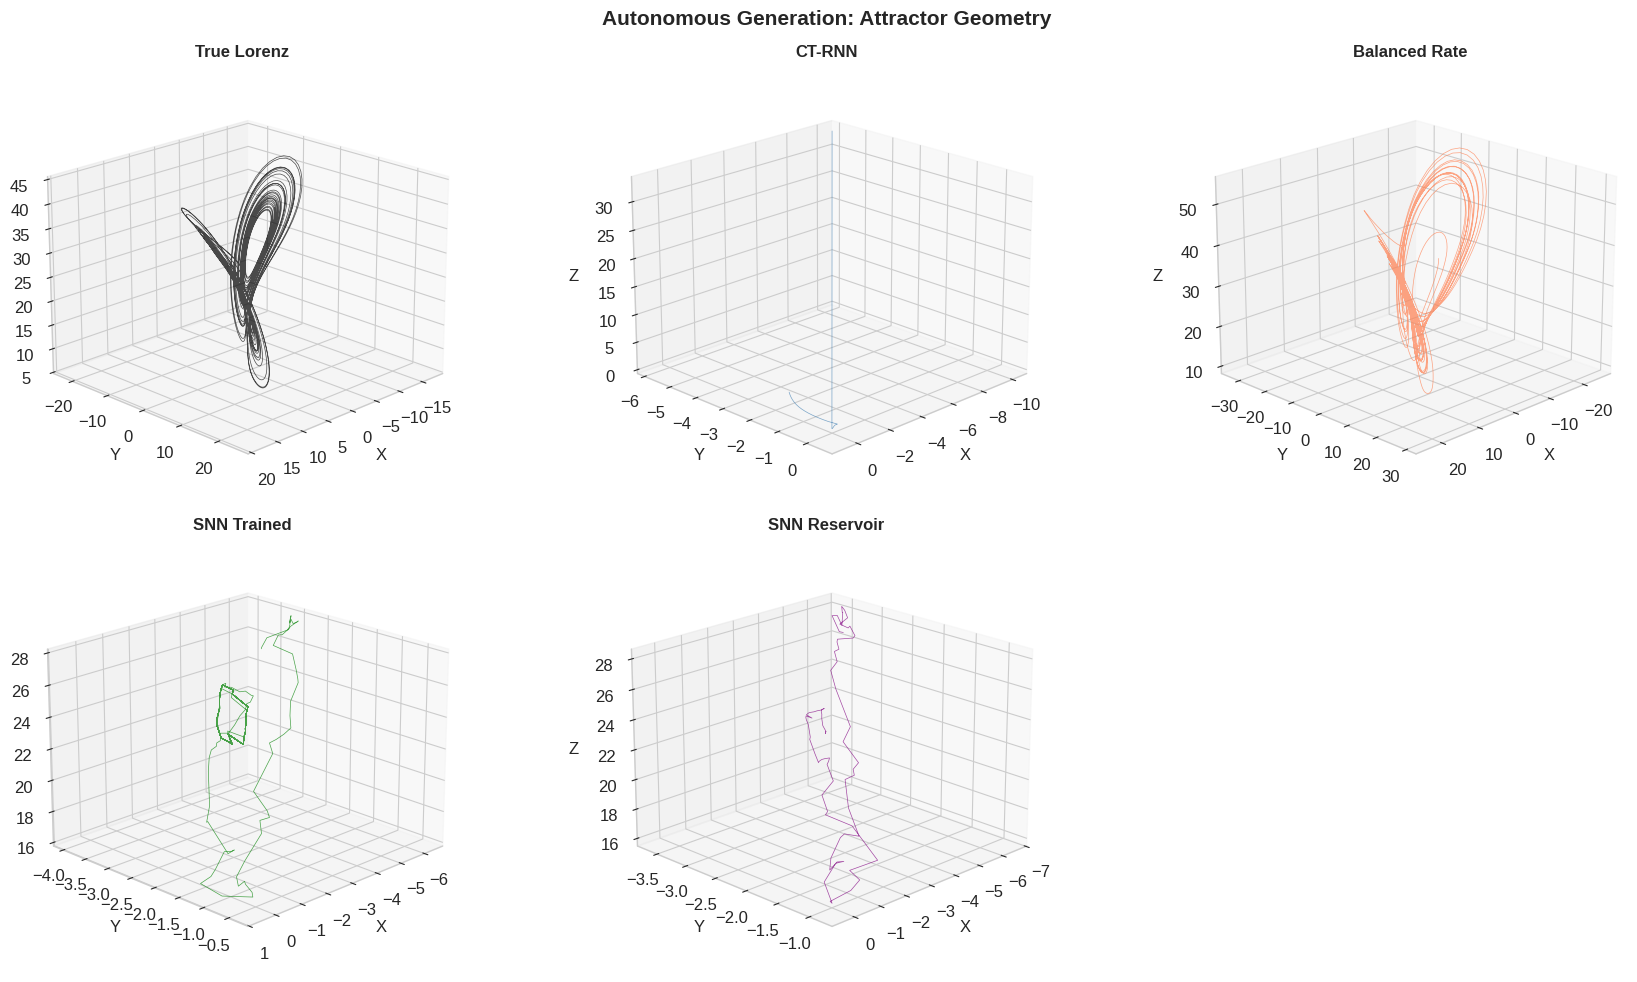

In [ ]:
# Visualize generated attractors
n_models = len(generated_trajectories)
n_cols = min(3, n_models + 1)
n_rows = (n_models + 1 + n_cols - 1) // n_cols

fig = plt.figure(figsize=(6*n_cols, 5*n_rows))

# True Lorenz
ax = fig.add_subplot(n_rows, n_cols, 1, projection='3d')
n_plot = min(3000, len(traj_lorenz_gen))
ax.plot(traj_lorenz_gen[:n_plot, 0], traj_lorenz_gen[:n_plot, 1], traj_lorenz_gen[:n_plot, 2],
        lw=0.5, alpha=0.7, color='black')
ax.set_title('True Lorenz', fontweight='bold', fontsize=12)
ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
ax.view_init(elev=20, azim=45)

# Generated attractors
colors = ['steelblue', 'coral', 'green', 'purple']
for idx, (model_name, trajectory) in enumerate(generated_trajectories.items(), start=2):
    ax = fig.add_subplot(n_rows, n_cols, idx, projection='3d')
    n_plot = min(3000, len(trajectory))
    color = colors[(idx-2) % len(colors)]
    ax.plot(trajectory[:n_plot, 0], trajectory[:n_plot, 1], trajectory[:n_plot, 2],
            lw=0.5, alpha=0.7, color=color)
    ax.set_title(model_name, fontweight='bold', fontsize=12)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.view_init(elev=20, azim=45)

plt.suptitle('Autonomous Generation: Attractor Geometry', fontsize=15, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

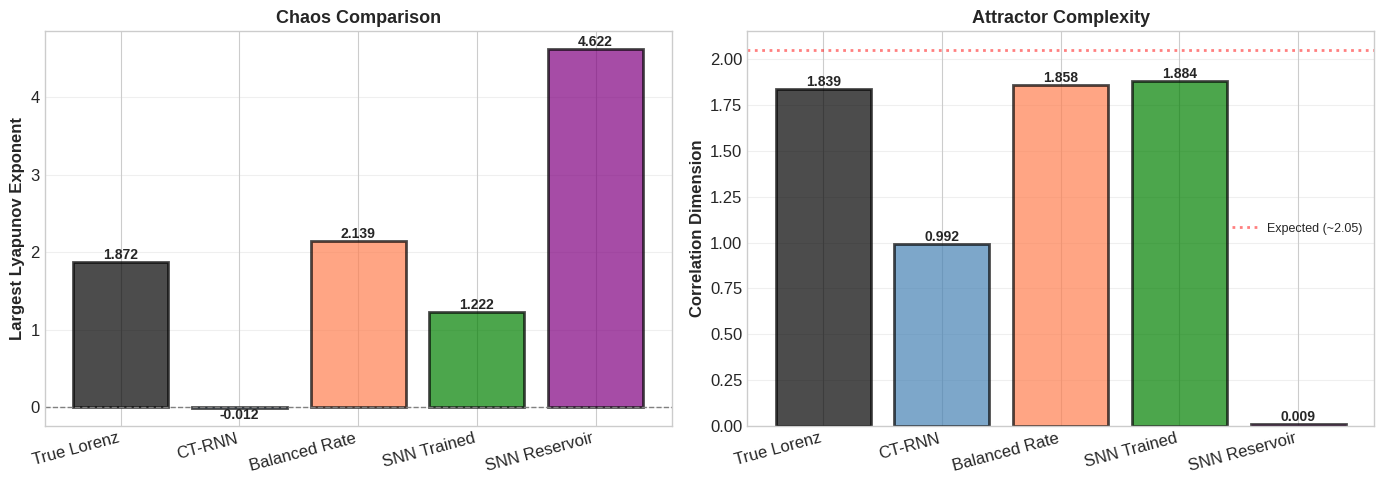


Dynamical Metrics (Generated Trajectories):
Model                Lyapunov     Dimension   
--------------------------------------------
True Lorenz               1.872        1.839
CT-RNN                   -0.012        0.992
Balanced Rate             2.139        1.858
SNN Trained               1.222        1.884
SNN Reservoir             4.622        0.009


In [ ]:
# Compute dynamical metrics from generated trajectories
from src.analysis import estimate_lyapunov_spectrum_simple, compute_attractor_dimension

# True Lorenz
lyap_true = estimate_lyapunov_spectrum_simple(traj_lorenz_gen, dt=gen_dt)
dim_true = compute_attractor_dimension(traj_lorenz_gen, n_points=2000)

# Generated trajectories
gen_metrics = {'True Lorenz': {'lyapunov': lyap_true, 'dimension': dim_true}}

for model_name, trajectory in generated_trajectories.items():
    lyap = estimate_lyapunov_spectrum_simple(trajectory, dt=gen_dt)
    dim = compute_attractor_dimension(trajectory, n_points=2000)
    gen_metrics[model_name] = {'lyapunov': lyap, 'dimension': dim}

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Lyapunov exponents
ax = axes[0]
names = list(gen_metrics.keys())
lyaps = [gen_metrics[n]['lyapunov'] for n in names]
colors_bar = ['black'] + colors[:len(names)-1]
bars = ax.bar(names, lyaps, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax.set_ylabel('Largest Lyapunov Exponent', fontsize=12, fontweight='bold')
ax.set_title('Chaos Comparison', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')
for bar, val in zip(bars, lyaps):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom' if val > 0 else 'top', 
            fontsize=10, fontweight='bold')

# Attractor dimensions
ax = axes[1]
dims = [gen_metrics[n]['dimension'] for n in names]
bars = ax.bar(names, dims, color=colors_bar, alpha=0.7, edgecolor='black', linewidth=2)
ax.axhline(y=2.05, color='red', linestyle=':', linewidth=2, alpha=0.5, label='Expected (~2.05)')
ax.set_ylabel('Correlation Dimension', fontsize=12, fontweight='bold')
ax.set_title('Attractor Complexity', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
ax.legend(fontsize=9)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=15, ha='right')
for bar, val in zip(bars, dims):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{val:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print table
print("\nDynamical Metrics (Generated Trajectories):")
print(f"{'Model':<20s} {'Lyapunov':<12s} {'Dimension':<12s}")
print("-" * 44)
for name in names:
    m = gen_metrics[name]
    print(f"{name:<20s} {m['lyapunov']:>10.3f}   {m['dimension']:>10.3f}")

## Part 5: Test Set Prediction Comparison

**One-step ahead prediction**: How well do models predict the next timestep given the current state?

In [ ]:
# One-step predictions comparison
if results:
    n_show = 500
    targets = list(results.values())[0]['targets']
    
    fig, axes = plt.subplots(3, 1, figsize=(16, 10), sharex=True)
    dim_names = ['X', 'Y', 'Z']
    colors_plot = {'CT-RNN': 'steelblue', 'Balanced Rate': 'coral', 
                   'SNN Trained': 'green', 'SNN Reservoir': 'purple'}
    
    for i, (ax, dim_name) in enumerate(zip(axes, dim_names)):
        ax.plot(targets[:n_show, i], color='black', linestyle='-', 
                label='True', linewidth=2, alpha=0.7)
        
        for model_name, data in results.items():
            preds = data['predictions']
            color = colors_plot.get(model_name, 'gray')
            r2 = data['metrics']['r2']
            ax.plot(preds[:n_show, i], color=color, linestyle='--', 
                    label=f'{model_name} (R²={r2:.4f})', linewidth=1.5, alpha=0.7)
        
        ax.set_ylabel(f'{dim_name}', fontsize=12, fontweight='bold')
        ax.legend(loc='upper right', fontsize=9)
        ax.grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Sample', fontsize=12)
    plt.suptitle('One-Step Predictions (Test Set)', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

NameError: name 'results' is not defined

In [ ]:
# Attractor reconstruction from test set
if results:
    n_models = len(results)
    n_cols = min(3, n_models + 1)
    n_rows = (n_models + 1 + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(6*n_cols, 5*n_rows))
    
    ax = fig.add_subplot(n_rows, n_cols, 1, projection='3d')
    targets = list(results.values())[0]['targets']
    n_show = min(2000, len(targets))
    ax.plot(targets[:n_show, 0], targets[:n_show, 1], targets[:n_show, 2],
             lw=0.5, alpha=0.6, color='black')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('True Lorenz', fontweight='bold')
    ax.view_init(elev=20, azim=45)
    
    colors_3d = ['steelblue', 'coral', 'green', 'purple']
    for idx, (model_name, data) in enumerate(results.items(), start=2):
        ax = fig.add_subplot(n_rows, n_cols, idx, projection='3d')
        preds = data['predictions']
        r2 = data['metrics']['r2']
        color = colors_3d[(idx-2) % len(colors_3d)]
        ax.plot(preds[:n_show, 0], preds[:n_show, 1], preds[:n_show, 2],
                 lw=0.5, alpha=0.6, color=color)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        ax.set_title(f'{model_name} (R²={r2:.4f})', fontweight='bold')
        ax.view_init(elev=20, azim=45)
    
    plt.suptitle('Test Set Attractor Reconstruction', fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

## Part 6: Summary & Key Findings

In [ ]:
# Compare attractor reconstructions from test set
if results:
    n_models = len(results)
    n_cols = min(3, n_models + 1)
    n_rows = (n_models + 1 + n_cols - 1) // n_cols
    
    fig = plt.figure(figsize=(6*n_cols, 5*n_rows))
    
    # True Lorenz attractor
    ax = fig.add_subplot(n_rows, n_cols, 1, projection='3d')
    targets = list(results.values())[0]['targets']
    n_show = min(2000, len(targets))
    ax.plot(targets[:n_show, 0], targets[:n_show, 1], targets[:n_show, 2],
             lw=0.5, alpha=0.6, color='black')
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title('True Lorenz\nAttractor', fontweight='bold')
    ax.view_init(elev=20, azim=45)
    
    # Model reconstructions
    colors_3d = ['steelblue', 'coral', 'green', 'purple']
    for idx, (model_name, data) in enumerate(results.items(), start=2):
        ax = fig.add_subplot(n_rows, n_cols, idx, projection='3d')
        preds = data['predictions']
        r2 = data['metrics']['r2']
        color = colors_3d[(idx-2) % len(colors_3d)]
        ax.plot(preds[:n_show, 0], preds[:n_show, 1], preds[:n_show, 2],
                 lw=0.5, alpha=0.6, color=color)
        ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
        ax.set_title(f'{model_name}\n(R²={r2:.4f})', fontweight='bold')
        ax.view_init(elev=20, azim=45)
    
    plt.suptitle('Test Set Attractor Reconstruction Comparison', 
                 fontsize=15, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
else:
    print("No models available for visualization.")